In [1]:
!git clone https://github.com/UoB-CS-AVAI/Week2-train-Deep-Neural-Network-to-denoise-image.git
!mv Week2-train-Deep-Neural-Network-to-denoise-image/* ./

Cloning into 'Week2-train-Deep-Neural-Network-to-denoise-image'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 37 (delta 6), reused 37 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 9.38 MiB | 6.71 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install lpips
!pip install torchmetrics
!pip install --upgrade pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 20.0 MB/s eta 0:00:00


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
from torchvision.utils import save_image
import numpy as np
from models import *
from PIL import Image
import torch
import torch.optim
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from pytorch_msssim import ssim  # For SSIM computation
import lpips  # For LPIPS computation
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from utils.denoising_utils import *
from models.downsampler import Downsampler


torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

use_gpu = True

if use_gpu:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.float32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = -1
factor = 8
enforse_div32 = 'CROP'
PLOT = True

In [6]:
def visualize_images_at_the_end(model_output, HR_np, LR_np, title1="DIP Super-Res Output",
                                title2="Original High-Res Image", title3="Low-Res Input Image x16",
                                save_path=None):
    """Visualizes the model output, original high-res image, and low-res input image."""
    # Process model output
    model_output_image = model_output.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
    model_output_image = np.clip(model_output_image, 0, 1)

    # Prepare high-res and low-res images
    image_hr_np = np.clip(HR_np, 0, 1)
    image_lr_np = np.clip(LR_np, 0, 1)

    # Transpose images to (H, W, C) if necessary
    if image_hr_np.shape[0] == 3:
        image_hr_np = np.transpose(image_hr_np, (1, 2, 0))
    if image_lr_np.shape[0] == 3:
        image_lr_np = np.transpose(image_lr_np, (1, 2, 0))

    # Plot images
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 1, 1)
    plt.imshow(image_hr_np)
    plt.title(title2)
    plt.axis('off')

    plt.subplot(3, 1, 2)
    plt.imshow(model_output_image)
    plt.title(title1)
    plt.axis('off')

    plt.subplot(3, 1, 3)
    plt.imshow(image_lr_np)
    plt.title(title3)
    plt.axis('off')

    if save_path:
        plt.savefig(save_path, format='png', bbox_inches='tight')
        print(f"Plot saved as: {save_path}")

    plt.show()


In [7]:
import torch
import torch.nn as nn
from models.common import *

def skip(
        num_input_channels=2, num_output_channels=3,
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4],
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True,
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU',
        need1x1_up=True):
    """Assembles encoder-decoder with skip connections.

    Arguments:
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')

    """
    assert len(num_channels_down) == len(num_channels_up) == len(num_channels_skip)

    n_scales = len(num_channels_down)

    if not (isinstance(upsample_mode, list) or isinstance(upsample_mode, tuple)) :
        upsample_mode   = [upsample_mode]*n_scales

    if not (isinstance(downsample_mode, list)or isinstance(downsample_mode, tuple)):
        downsample_mode   = [downsample_mode]*n_scales

    if not (isinstance(filter_size_down, list) or isinstance(filter_size_down, tuple)) :
        filter_size_down   = [filter_size_down]*n_scales

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
        filter_size_up   = [filter_size_up]*n_scales

    last_scale = n_scales - 1

    cur_depth = None

    model = nn.Sequential()
    model_tmp = model

    input_depth = num_input_channels
    for i in range(len(num_channels_down)):

        deeper = nn.Sequential()
        skip = nn.Sequential()

        if num_channels_skip[i] != 0:
            model_tmp.add(Concat(1, skip, deeper))
        else:
            model_tmp.add(deeper)

        model_tmp.add(bn(num_channels_skip[i] + (num_channels_up[i + 1] if i < last_scale else num_channels_down[i])))

        if num_channels_skip[i] != 0:
            skip.add(conv(input_depth, num_channels_skip[i], filter_skip_size, bias=need_bias, pad=pad))
            skip.add(bn(num_channels_skip[i]))
            skip.add(act(act_fun))

        # skip.add(Concat(2, GenNoise(nums_noise[i]), skip_part))

        deeper.add(conv(input_depth, num_channels_down[i], filter_size_down[i], 2, bias=need_bias, pad=pad, downsample_mode=downsample_mode[i]))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper.add(conv(num_channels_down[i], num_channels_down[i], filter_size_down[i], bias=need_bias, pad=pad))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper_main = nn.Sequential()

        if i == len(num_channels_down) - 1:
            # The deepest
            k = num_channels_down[i]
        else:
            deeper.add(deeper_main)
            k = num_channels_up[i + 1]

        deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode[i]))

        model_tmp.add(conv(num_channels_skip[i] + k, num_channels_up[i], filter_size_up[i], 1, bias=need_bias, pad=pad))
        model_tmp.add(bn(num_channels_up[i]))
        model_tmp.add(act(act_fun))


        if need1x1_up:
            model_tmp.add(conv(num_channels_up[i], num_channels_up[i], 1, bias=need_bias, pad=pad))
            model_tmp.add(bn(num_channels_up[i]))
            model_tmp.add(act(act_fun))

        input_depth = num_channels_down[i]
        model_tmp = deeper_main

    model.add(conv(num_channels_up[0], num_output_channels, 1, bias=need_bias, pad=pad))
    if need_sigmoid:
        model.add(nn.Sigmoid())

    return model

In [8]:
downsampler_x2 = Downsampler(n_planes=3, factor=2, kernel_type="box", phase=0.5, kernel_width=2, preserve_size=True).to(device)

def process_image_with_downsampler(image_lr, downsampler, device, height, width, boolUpsample=True):
    # Step 1: Convert PIL image to PyTorch tensor
    image_lr_np = np.array(image_lr).astype(np.float32) / 255.0  # Normalize to [0, 1]
    image_lr_tensor = torch.tensor(image_lr_np).permute(2, 0, 1).unsqueeze(0).to(device)  # Shape: (1, 3, H, W)

    # Step 2: Apply downsampling
    image_downsampled = downsampler(image_lr_tensor)

    if boolUpsample:
        image_upsampled = F.interpolate(image_downsampled, size=(height, width), mode='nearest')
        image_result = image_upsampled.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Shape: (H, W, 3)
    else:
      image_result = image_downsampled.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Shape: (H, W, 3)

    image_result = (image_result * 255.0).clip(0, 255).astype(np.uint8)  # Convert back to [0, 255]
    image_pil = Image.fromarray(image_result)

    return image_pil

Width_lr: 2016, Height_lr: 1152
Width_lr: 2016, Height_lr: 1152


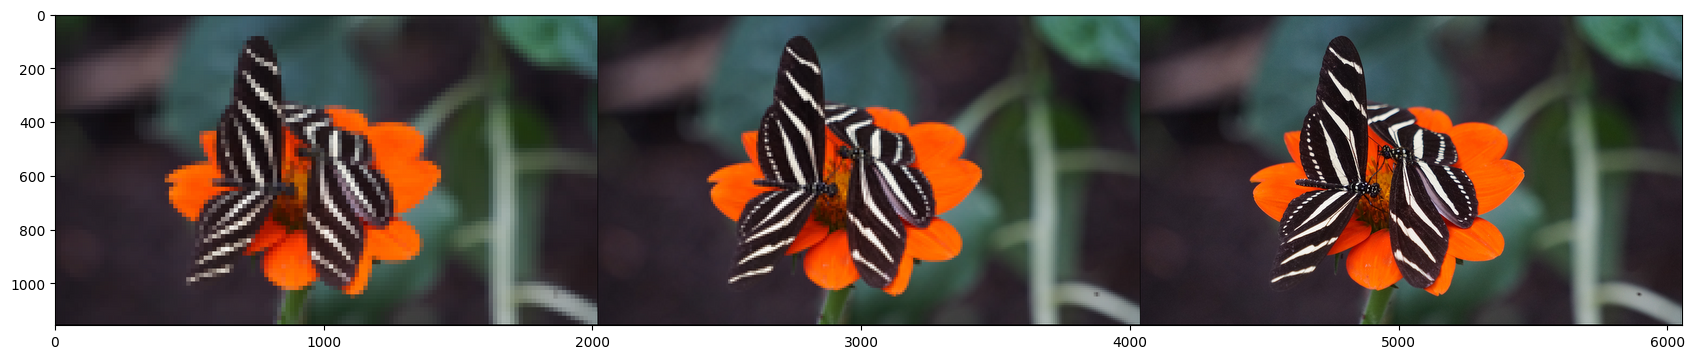

In [10]:
# Helper function to resize the image
def resize_image(img_pil, target_size):
    return img_pil.resize(target_size, Image.NEAREST)

def resize_image_bicubic(img_pil, target_size):
    return img_pil.resize(target_size, Image.BICUBIC)


#img_index = '0465'
#img_index = '0170'
#img_index = '0025'
img_index = '0185'
#img_index = '0745'
out_path = '/content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/DIP_OUTPUT_x16/' + img_index + '/'
fname_hr = '/content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/DIV2K_train_HR/' + img_index + '.png'
fname_lr = '/content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/DIV2K_train_LR_x8/' + img_index + 'x8.png'

HR_pil = Image.open(fname_hr)
HR_np = pil_to_np(HR_pil)
hr_width, hr_height = HR_pil.size


LR_pil = Image.open(fname_lr)

image_lr_visualise_x8_pil = resize_image(LR_pil, (hr_width, hr_height))
image_lr_visualise_x8_np = pil_to_np(image_lr_visualise_x8_pil)

LR_pil = process_image_with_downsampler(LR_pil, downsampler_x2, device, hr_height, hr_width)
LR_np = pil_to_np(LR_pil)


# Crop images (if needed)
LR_pil = crop_image(LR_pil, d=32)
LR_np = pil_to_np(LR_pil)

image_lr_visualise_x8_pil = crop_image(image_lr_visualise_x8_pil, d=32)
image_lr_visualise_x8_np = pil_to_np(image_lr_visualise_x8_pil)

HR_pil = crop_image(HR_pil, d=32)
HR_np = pil_to_np(HR_pil)

width_hr, height_hr = HR_pil.size
print(f"Width_lr: {width_hr}, Height_lr: {height_hr}")
width_lr, height_lr = LR_pil.size
print(f"Width_lr: {width_lr}, Height_lr: {height_lr}")

# Plot if required
if PLOT:
    plot_image_grid([LR_np, image_lr_visualise_x8_np, HR_np], 12, 18)



In [10]:
from models.texture_nets import get_texture_nets
from models.resnet import ResNet
from models.unet import UNet

import torch.nn as nn

def get_net(input_depth, NET_TYPE, pad, upsample_mode, n_channels=3, act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4, num_scales=5, downsample_mode='stride'):
    if NET_TYPE == 'ResNet':

        net = ResNet(input_depth, 3, 10, 16, 1, nn.BatchNorm2d, False)
    elif NET_TYPE == 'skip':
        net = skip(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales if isinstance(skip_n33d, int) else skip_n33d,
                                            num_channels_up =   [skip_n33u]*num_scales if isinstance(skip_n33u, int) else skip_n33u,
                                            num_channels_skip = [skip_n11]*num_scales if isinstance(skip_n11, int) else skip_n11,
                                            upsample_mode=upsample_mode, downsample_mode=downsample_mode,
                                            need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun)

    elif NET_TYPE == 'texture_nets':
        net = get_texture_nets(inp=input_depth, ratios = [32, 16, 8, 4, 2, 1], fill_noise=False,pad=pad)

    elif NET_TYPE =='UNet':
        net = UNet(num_input_channels=input_depth, num_output_channels=3,
                   feature_scale=4, more_layers=0, concat_x=False,
                   upsample_mode=upsample_mode, pad=pad, norm_layer=nn.BatchNorm2d, need_sigmoid=True, need_bias=True)
    elif NET_TYPE == 'identity':
        assert input_depth == 3
        net = nn.Sequential()
    else:
        assert False

    return net


input_depth = 32
pad = 'reflection'
OPT_OVER = 'net'
#blur_type = 'lanczos2'
#blur_type = 'box'
LR = 0.0005
tv_weight = 0.0
OPTIMIZER = 'adam'
factor = 16
num_iter = 4000
reg_noise_std = 0.05

# HR_pil.size is thesame as LR_pil.size
net_input = get_noise(input_depth, 'noise', (HR_pil.size[1], HR_pil.size[0])).type(dtype).detach()

#shape = [1, input_depth, LR_pil.size[1], LR_pil.size[0]]
#net_input = torch.zeros(shape).type(dtype).detach()
print("net_input.requires_grad:", net_input.requires_grad)
NET_TYPE = 'skip'
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128,
              skip_n33u=128,
              skip_n11=4,
              num_scales=5,
              upsample_mode='bilinear').type(dtype)


mse = torch.nn.MSELoss().type(dtype)
img_LR_var = np_to_torch(LR_np).type(dtype)

#blur_type = 'lanczos2'

# Downsampler x16
blur_type = 'box'
downsampler = Downsampler(n_planes=3, factor=16, kernel_type=blur_type, phase=0.5, kernel_width=16, preserve_size=True).type(dtype)

net_input.requires_grad: False


In [11]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lpips_loss_fn = lpips.LPIPS(net='alex').to(device)
#accum_iter = 4

def closure():
    global i, net_input, img_LR_var

    with torch.no_grad():
        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    img_LR_var = img_LR_var.to(out_LR.device)

    # upsample to orig size, so x16
    out_LR = F.interpolate(out_LR, size=img_LR_var.shape[2:], mode='nearest')

    total_loss = mse(out_LR, img_LR_var)


    # source:
    # https://github.com/DmitryUlyanov/deep-image-prior/blob/master/super-resolution.ipynb
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)

    total_loss.backward()



    if (PLOT and i % 50 == 0) or i == num_iter-1:
        with torch.no_grad():
            psnr_LR = compare_psnr(LR_np, torch_to_np(out_LR))
            psnr_HR = compare_psnr(HR_np, torch_to_np(out_HR))

            # ground truth high-res for validation
            HR_tensor = torch.from_numpy(HR_np).unsqueeze(0).to(out_HR.device).float()

            # model's predicted high-res output
            out_HR_01 = torch.clamp(out_HR, 0, 1)

            # ground truth high-res for validation
            HR_tensor_01 = torch.clamp(HR_tensor, 0, 1)

            ssim_value = ssim(out_HR_01, HR_tensor_01, data_range=1.0, size_average=True)

            # model's predicted high-res output
            out_HR_lpips = out_HR_01 * 2 - 1

            # ground truth high-res for validation
            HR_tensor_lpips = HR_tensor_01 * 2 - 1

            lpips_value = lpips_loss_fn(out_HR_lpips, HR_tensor_lpips)
            print('iter:', i, 'total_loss:', total_loss.item(), 'psnr_LR:', psnr_LR, 'psnr_HR:', psnr_HR, 'ssim_value:', ssim_value.item(), 'lpips_value:', lpips_value.item())

    if (PLOT and i % 200 == 0) or i == num_iter-1:
        with torch.no_grad():
            out_HR_np = torch_to_np(out_HR)
            plot_image_grid([LR_np, np.clip(out_HR_np, 0, 1), HR_np], factor=13, nrow=3)

            # Save model output image
            model_output_img = out_HR_01.clone().detach()
            #sv_path = os.path.join(out_path, f'output_image_{img_index}_iter_{i}.png')
            #save_image(model_output_img, sv_path)
            psnr_history.append([i, psnr_LR, psnr_HR, ssim_value.item(), lpips_value.item(), total_loss.item()])

            # Save evaluation metrics to a text file
            #metrics_path = os.path.join(out_path, f'eval_qual_metrics_{img_index}.txt')
            #with open(metrics_path, 'a') as file:
            #    file.write(f"Step {i:05d}, PSNR_LR {psnr_LR:.3f}, PSNR_HR {psnr_HR:.3f}, Loss {total_loss.item():.6f}, SSIM {ssim_value.item():.6f}, LPIPS {lpips_value.item():.6f}\n")

    if i == num_iter-1:
        with torch.no_grad():
            # Prepare model output for visualization
            model_output_img = out_HR_01.clone().detach()

            sv_path = out_path + 'output_image_' + img_index + '.png'

            save_image(model_output_img, sv_path)

            # Call the visualization function
            sv_path = os.path.join(out_path, f'output_image_grid_{img_index}_.png')
            visualize_images_at_the_end(model_output_img, HR_np, LR_np, save_path=sv_path)

    del out_HR, out_LR  # Delete intermediate variables to free memory
    torch.cuda.empty_cache()

    i += 1


    return total_loss

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

In [12]:
LR = 0.0005
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
#model_output_img = None
psnr_history = []
i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
print("PSNR History (Iteration-wise):")

steps = []
psnr_hrs = []
ssims = []
lpipss = []

for idx, (step, psnr_LR, psnr_HR, ssim_value, lpips_value, loss_value) in enumerate(psnr_history):
    steps.append(step)
    psnr_hrs.append(psnr_HR)
    ssims.append(ssim_value)
    lpipss.append(lpips_value)
    print(f"Step {step} - PSNR_LR: {psnr_LR:.3f}, PSNR_HR: {psnr_HR:.3f}, Loss: {loss_value:.6f}, SSIM: {ssim_value:.4f}, LPIPS: {lpips_value:.4f}")

    # Save metrics to a text file
    metrics_path = os.path.join(out_path, f'eval_qual_metrics_{img_index}.txt')
    with open(metrics_path, "a") as file:
        file.write(f"Step {step} - PSNR_LR: {psnr_LR:.3f}, PSNR_HR: {psnr_HR:.3f}, Loss: {loss_value:.6f}, SSIM: {ssim_value:.6f}, LPIPS: {lpips_value:.6f}\n")


PSNR History (Iteration-wise):
Step 0 - PSNR_LR: 8.599, PSNR_HR: 8.228, Loss: 0.138059, SSIM: 0.1897, LPIPS: 1.0212
Step 200 - PSNR_LR: 19.335, PSNR_HR: 16.888, Loss: 0.011654, SSIM: 0.4235, LPIPS: 0.6842
Step 400 - PSNR_LR: 20.841, PSNR_HR: 17.885, Loss: 0.008239, SSIM: 0.4686, LPIPS: 0.6479
Step 600 - PSNR_LR: 21.675, PSNR_HR: 18.538, Loss: 0.006800, SSIM: 0.5029, LPIPS: 0.6035
Step 800 - PSNR_LR: 22.176, PSNR_HR: 18.663, Loss: 0.006059, SSIM: 0.5237, LPIPS: 0.5916
Step 1000 - PSNR_LR: 22.496, PSNR_HR: 18.890, Loss: 0.005628, SSIM: 0.5395, LPIPS: 0.5807
Step 1200 - PSNR_LR: 22.727, PSNR_HR: 19.126, Loss: 0.005337, SSIM: 0.5547, LPIPS: 0.5682
Step 1400 - PSNR_LR: 22.839, PSNR_HR: 19.110, Loss: 0.005201, SSIM: 0.5630, LPIPS: 0.5631
Step 1600 - PSNR_LR: 22.976, PSNR_HR: 19.159, Loss: 0.005039, SSIM: 0.5697, LPIPS: 0.5566
Step 1800 - PSNR_LR: 23.068, PSNR_HR: 19.280, Loss: 0.004934, SSIM: 0.5770, LPIPS: 0.5549
Step 2000 - PSNR_LR: 23.120, PSNR_HR: 19.289, Loss: 0.004875, SSIM: 0.5808, LP

Plot saved as: /content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/DIP_OUTPUT_x16/0465/plot_0465.png


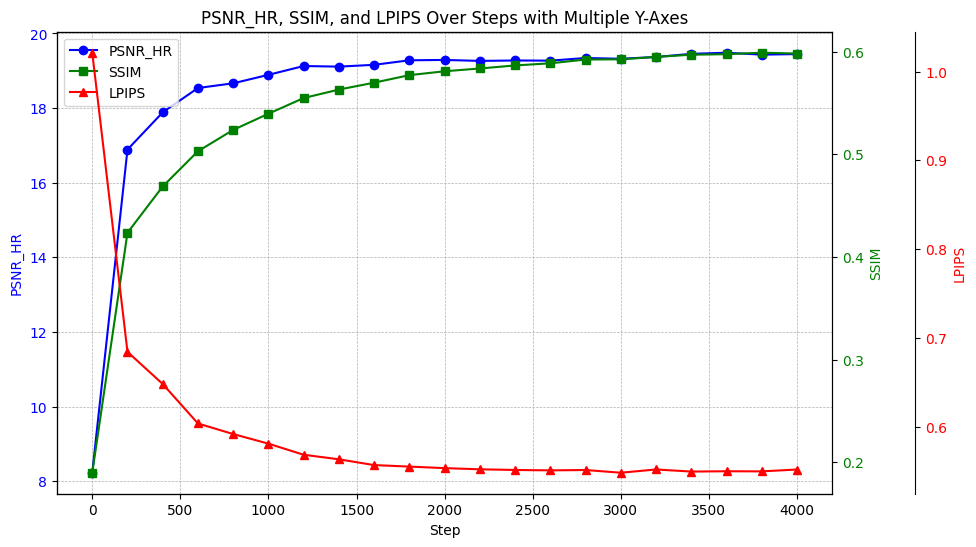

In [14]:
import matplotlib.pyplot as plt

# Create the main figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot PSNR_HR on the primary y-axis
ax1.plot(steps, psnr_hrs, 'b-o', label='PSNR_HR')
ax1.set_xlabel('Step')
ax1.set_ylabel('PSNR_HR', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for SSIM
ax2 = ax1.twinx()
ax2.plot(steps, ssims, 'g-s', label='SSIM')
ax2.set_ylabel('SSIM', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Create a tertiary y-axis for LPIPS
# Offset the spine to make room for the third axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(steps, lpipss, 'r-^', label='LPIPS')
ax3.set_ylabel('LPIPS', color='r')
ax3.tick_params(axis='y', labelcolor='r')

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

# Add a grid
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Set the title
plt.title('PSNR_HR, SSIM, and LPIPS Over Steps with Multiple Y-Axes')

# Save the plot
save_path = os.path.join(out_path, f'plot_{img_index}.png')
plt.savefig(save_path, format='png', bbox_inches='tight')
print(f"Plot saved as: {save_path}")

# Show the plot
plt.show()


In [11]:
def resize_image_bicubic(img_pil, target_size):
    return img_pil.resize(target_size, Image.BICUBIC)

# Load the low-resolution image
image_lr_test = LR_pil
image_hr_test = Image.open(fname_hr)

# Upscale using bicubic interpolation
image_lr_test = resize_image_bicubic(image_lr_test, (hr_width, hr_height))

# Save the bicubic upsampled image
bicubic_save_path = os.path.join(out_path, f'bicubic_upsampled_{img_index}.png')
image_lr_test.save(bicubic_save_path)
print(f"Bicubic upsampled image saved at {bicubic_save_path}")

image_lr_test_np = np.array(image_lr_test).astype(np.float32) / 255.0  # Normalize to [0, 1]
input_image_hr_np = np.array(image_hr_test).astype(np.float32) / 255.0
# Compute PSNR between bicubic upsampled image and high-res image
psnr_bicubic = compare_psnr(input_image_hr_np, image_lr_test_np)

# Save the result to a text file
save_path = os.path.join(out_path, f'eval_qual_metrics_{img_index}.txt')
with open(save_path, "a") as file:
    file.write(f"BICUBIC PSNR: {psnr_bicubic:.6f}\n")

# Print to console
print('BICUBIC PSNR:', psnr_bicubic)

Bicubic upsampled image saved at /content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/DIP_OUTPUT_x16/0185/bicubic_upsampled_0185.png
BICUBIC PSNR: 21.39368108340474
